<a href="https://colab.research.google.com/github/seongcho1/mnetest/blob/main/eeg_motor_imagery_005_Removing_muscle_ICA_components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Removing muscle ICA components
Gross movements produce widespread high-frequency activity across all channels that is usually not recoverable and so the epoch must be rejected as shown in Annotate muscle artifacts. More ubiquitously than gross movements, muscle artifact is produced during postural maintenance. This is more appropriately removed by ICA otherwise there wouldn’t be any epochs left! Note that muscle artifacts of this kind are much more pronounced in EEG than they are in MEG.

https://mne.tools/stable/auto_examples/preprocessing/muscle_ica.html

In [2]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 42.8 MB/s eta 0:00:00


In [54]:
import mne
from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci

event_id = dict(hands=2, feet=3)  # motor imagery: hands vs feet
subject = 1
#runs = [6, 10, 14]
runs = [1, ]

raw = mne.io.read_raw_edf(
    mne.datasets.eegbci.load_data(subject=subject, runs=runs)[0], preload=True)

mne.datasets.eegbci.standardize(raw)  # set channel names
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)
raw.filter(l_freq=1., h_freq=None)


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


<RawEDF | S001R01.edf, 64 x 9760 (61.0 s), ~4.9 MB, data loaded>

Run ICA

In [55]:
!pip install python-picard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
ica = mne.preprocessing.ICA(n_components=15, method='picard', max_iter='auto', random_state=97)
ica.fit(raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.8s.


Method,picard
Fit,46 iterations on raw data (9760 samples)
ICA components,15
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Remove components with postural muscle artifact using ICA

Creating RawArray with float64 data, n_channels=15, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


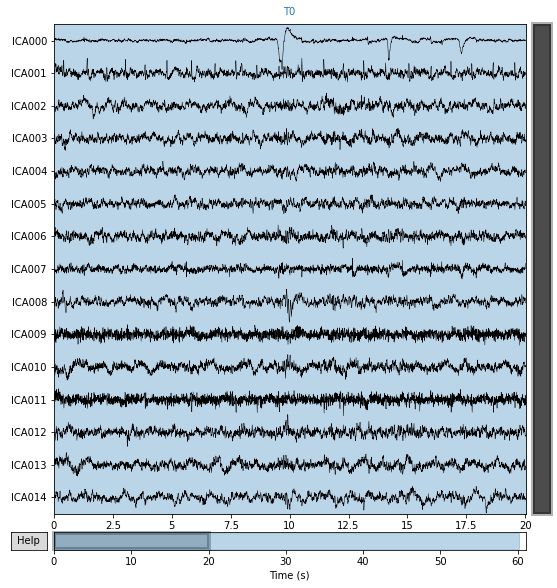

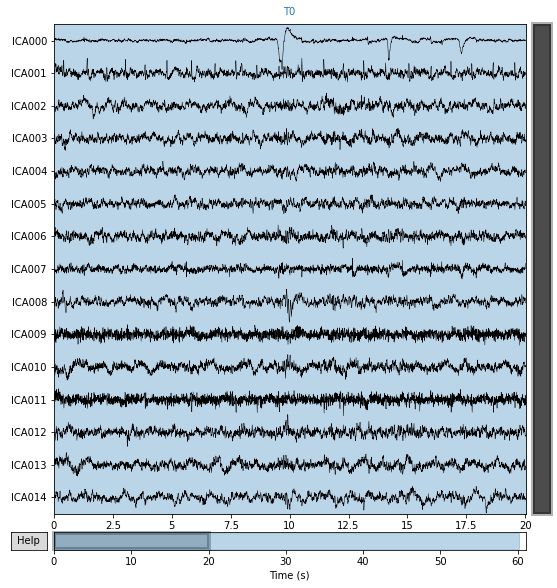

In [57]:
ica.plot_sources(raw)

By inspection, let’s select out the muscle-artifact components based on [1] manually.


The criteria are:


- Positive slope of log-log power spectrum between 7 and 75 Hz (here just flat because it’s not in log-log)

- Peripheral focus or dipole/multi-pole foci (the blue and red blobs in the topomap are far from the vertex where the most muscle is)

- Single focal point (low spatial smoothness; there is just one focus of the topomap compared to components like the first ones that are more likely neural which spread across the topomap)


The other attribute worth noting is that the time course in mne.preprocessing.ICA.plot_sources() looks like EMG; you can see spikes when each motor unit fires so that the time course looks fuzzy and sometimes has large spikes that are often at regular intervals.

ICA component 13 is a textbook example of what muscle artifact looks like. The focus of the topomap for this component is right on the temporalis muscle near the ears. There is also a minimum in the power spectrum at around 10 Hz, then a maximum at around 25 Hz, generally resulting in a positive slope in log-log units; this is a very typical pattern for muscle artifact.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection i

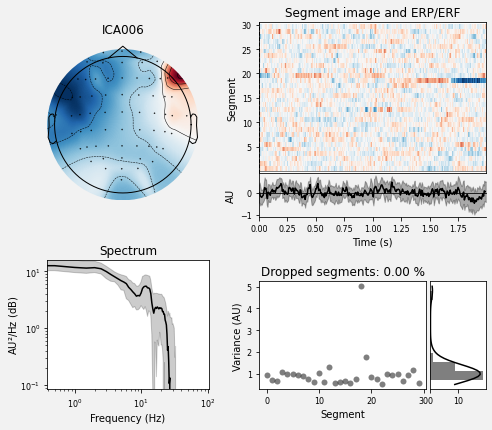

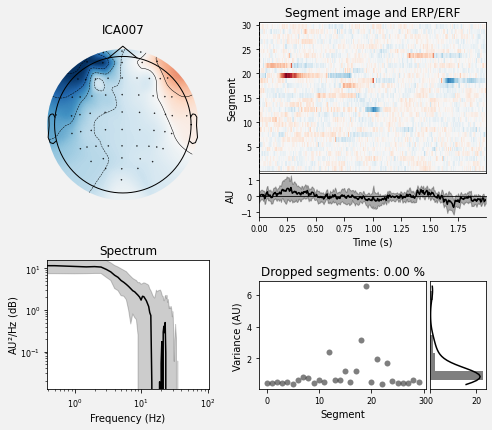

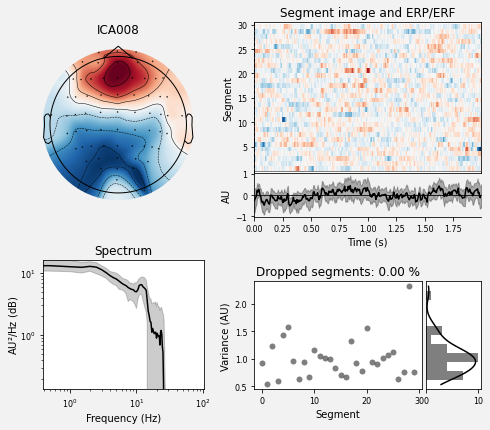

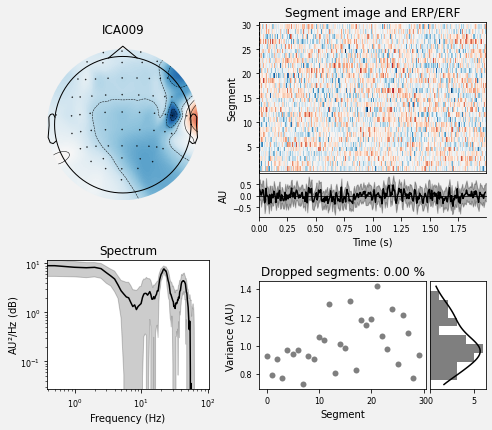

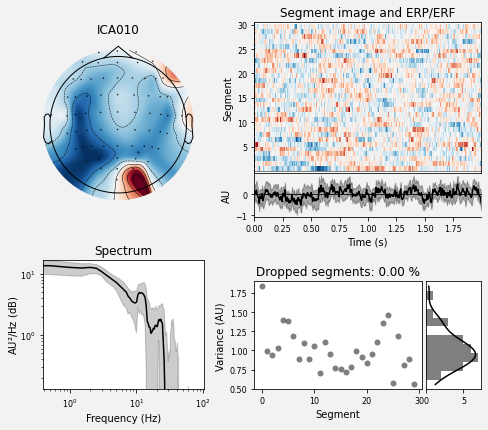

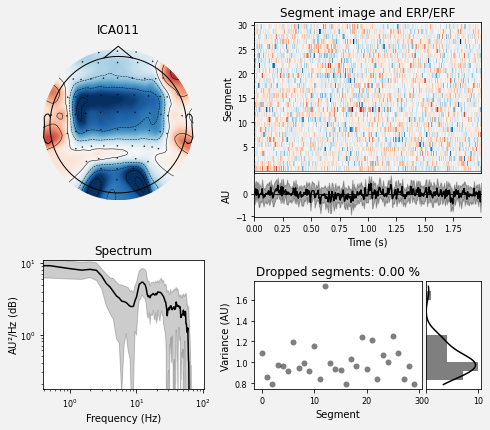

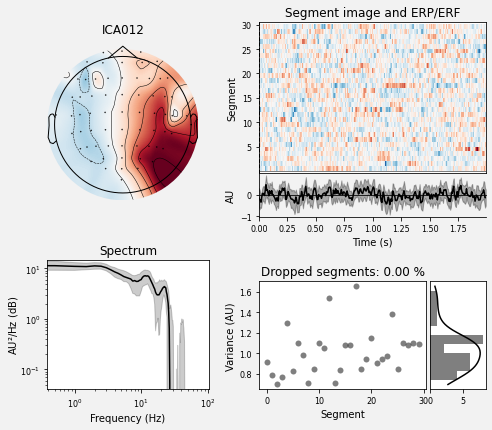

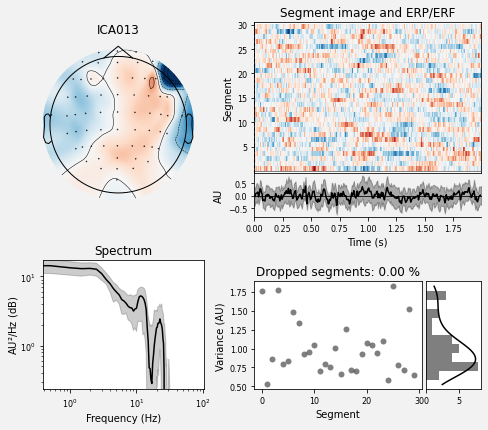

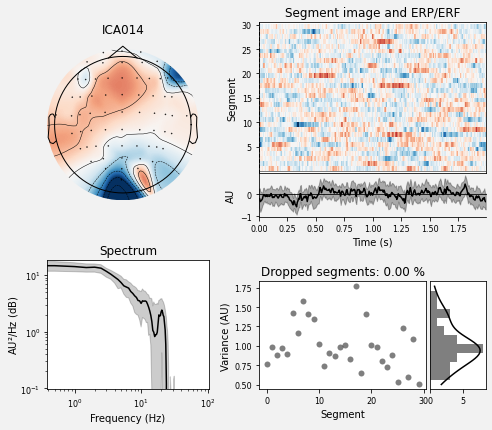

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 9 ICA components
    Projecting back using 64 PCA components


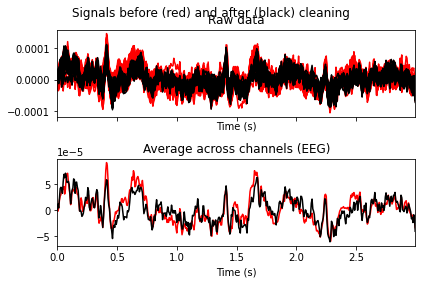

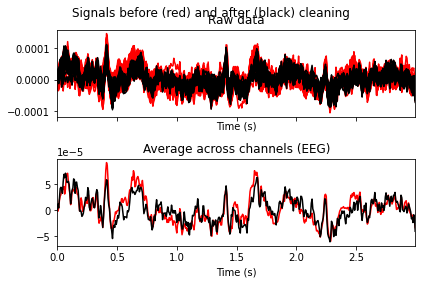

In [61]:
muscle_idx = [6, 7, 8, 9, 10, 11, 12, 13, 14]
ica.plot_properties(raw, picks=muscle_idx, log_scale=True)

# first, remove blinks and heartbeat to compare
blink_idx = [0]
heartbeat_idx = [5]
ica.apply(raw, exclude=blink_idx + heartbeat_idx)
ica.plot_overlay(raw, exclude=muscle_idx)

Finally, let’s try an automated algorithm to find muscle components and ensure that it gets the same components we did manually.

Effective window size : 1.600 (s)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


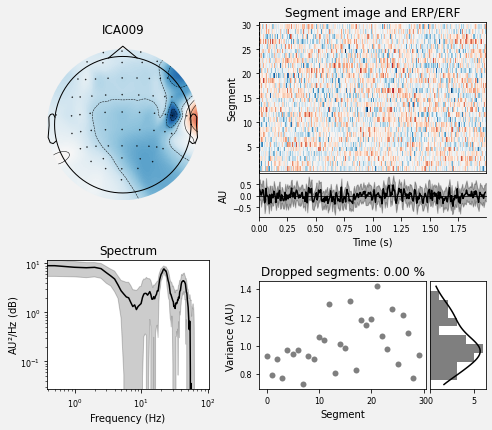

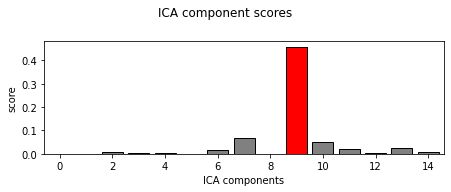

Manually found muscle artifact ICA components:      [6, 7, 8, 9, 10, 11, 12, 13, 14]
Automatically found muscle artifact ICA components: [9]


In [60]:
muscle_idx_auto, scores = ica.find_bads_muscle(raw)
ica.plot_properties(raw, picks=muscle_idx_auto, log_scale=True)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(f'Manually found muscle artifact ICA components:      {muscle_idx}\n'
      f'Automatically found muscle artifact ICA components: {muscle_idx_auto}')

# Let’s now replicate this on the EEGBCI dataset

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 sec)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Fitting ICA took 1.2s.
Creating RawArray with float64 data, n_channels=15, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


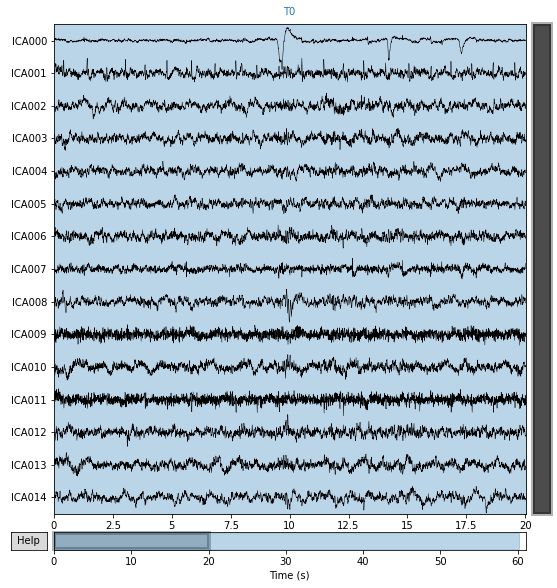

Effective window size : 1.600 (s)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


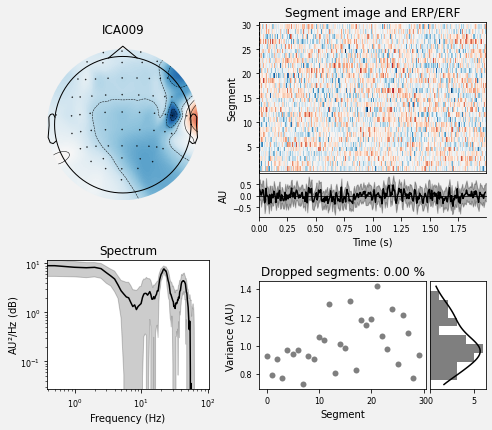

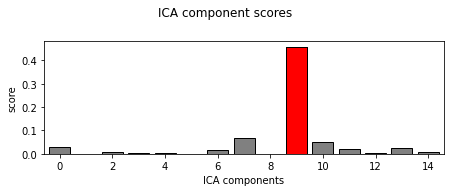

Manually found muscle artifact ICA components:      [6, 7, 8, 9, 10, 11, 12, 13, 14]
Automatically found muscle artifact ICA components: [9]
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 sec)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Fitting ICA took 1.4s.
Creating RawArray with float64 data, n_channels=15, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


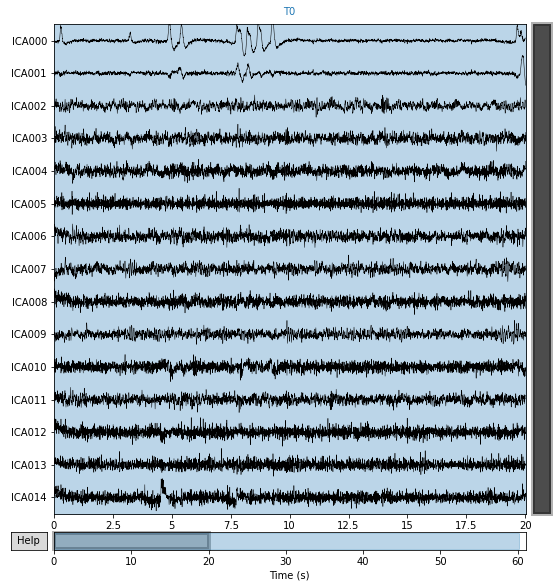

Effective window size : 1.600 (s)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


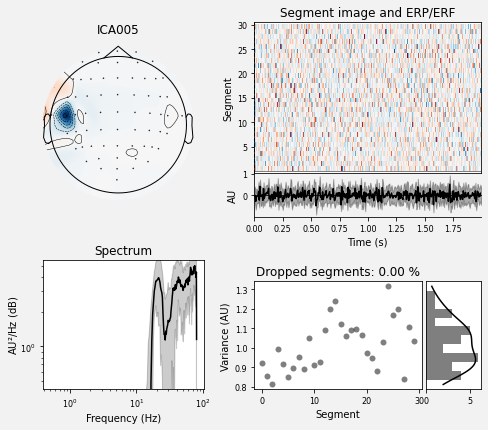

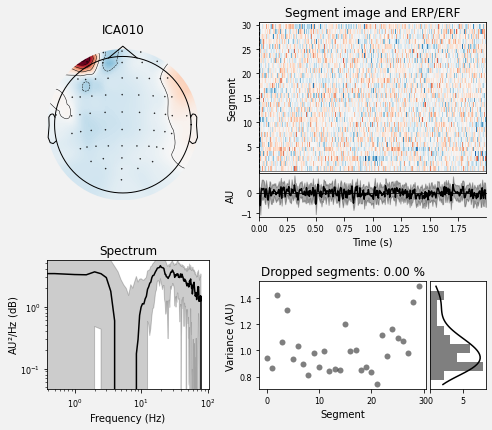

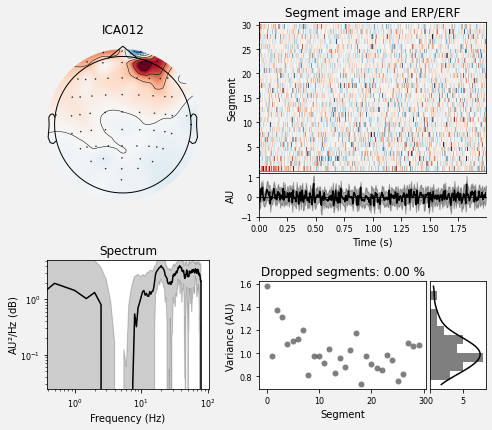

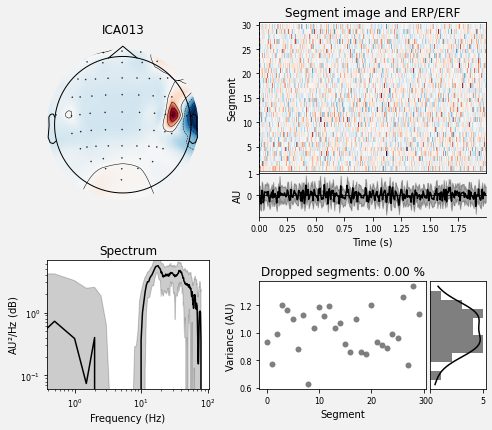

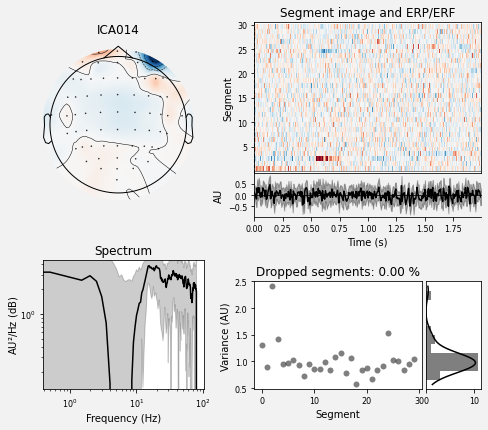

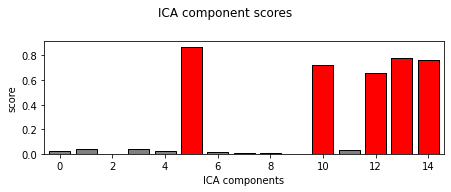

Manually found muscle artifact ICA components:      [6, 7, 8, 9, 10, 11, 12, 13, 14]
Automatically found muscle artifact ICA components: [5, 10, 12, 13, 14]


In [62]:
for sub in (1, 2):
    raw = mne.io.read_raw_edf(
        mne.datasets.eegbci.load_data(subject=sub, runs=(1,))[0], preload=True)
    mne.datasets.eegbci.standardize(raw)  # set channel names
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)
    raw.filter(l_freq=1., h_freq=None)

    # Run ICA
    ica = mne.preprocessing.ICA(
        n_components=15, method='picard', max_iter='auto', random_state=97)
    ica.fit(raw)
    ica.plot_sources(raw)
    muscle_idx_auto, scores = ica.find_bads_muscle(raw)
    ica.plot_properties(raw, picks=muscle_idx_auto, log_scale=True)
    ica.plot_scores(scores, exclude=muscle_idx_auto)

    print(f'Manually found muscle artifact ICA components:      {muscle_idx}\n'
          'Automatically found muscle artifact ICA components: '
          f'{muscle_idx_auto}')